In [1]:
"""
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# BƯỚC 1: TẢI VÀ CHUẨN BỊ DỮ LIỆU (PHIÊN BẢN CẢI TIẾN)
# ==============================================================================
print("BƯỚC 1: Tải và chuẩn bị dữ liệu...")

# Tải dữ liệu, để Pandas tự động nhận diện header và tránh cảnh báo
# Thay 'unsupervised_dataset.csv' và 'evaluation_dataset.csv' bằng tên file của bạn
try:
    train_df = pd.read_csv('unsupervised_dataset.csv', low_memory=False)
    test_df = pd.read_csv('evaluation_dataset.csv', low_memory=False)
except FileNotFoundError:
    print("LỖI: Không tìm thấy file 'unsupervised_dataset.csv' hoặc 'evaluation_dataset.csv'.")
    print("Vui lòng đảm bảo các file CSV nằm trong cùng thư mục với script.")
    exit()

print(f"Kích thước dữ liệu train ban đầu: {train_df.shape}")
print(f"Kích thước dữ liệu test ban đầu: {test_df.shape}")

# --- Xử lý dữ liệu train ---
# Ép kiểu tất cả các cột thành số, giá trị không phải số sẽ thành NaN
for col in train_df.columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
# Thay thế các giá trị NaN bằng 0
train_df.fillna(0, inplace=True)

# --- Xử lý dữ liệu test ---
# Xác định tên cột nhãn (cột cuối cùng)
label_column_name = test_df.columns[-1] 
feature_columns = test_df.columns[:-1]
# Ép kiểu các cột đặc trưng thành số
for col in feature_columns:
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
# Thay thế các giá trị NaN bằng 0
test_df.fillna(0, inplace=True)

print("Đã ép kiểu dữ liệu và xử lý giá trị thiếu thành công.")

# Tách dữ liệu (X) và nhãn (y) cho tập test
X_test_full = test_df.drop(columns=[label_column_name]).values
y_test_full = test_df[label_column_name].values

# Chuyển nhãn từ {-1 (abnormal), 1 (normal)} thành {1 (abnormal), 0 (normal)}
y_test_binary = np.where(y_test_full == -1, 1, 0)

# Dữ liệu train chính là X_train
X_train_full = train_df.values

# Chuẩn hóa dữ liệu về khoảng [0, 1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

print("Chuẩn bị dữ liệu hoàn tất.\n")


# ==============================================================================
# BƯỚC 2: XÂY DỰNG VÀ HUẤN LUYỆN AUTOENCODER GIẢM CHIỀU
# ==============================================================================
print("BƯỚC 2: Xây dựng và huấn luyện Autoencoder giảm chiều...")

input_dim = X_train_scaled.shape[1]
# Kích thước không gian tiềm ẩn (số chiều sau khi giảm)
encoding_dim = int(input_dim / 2) 

# Định nghĩa kiến trúc mô hình
input_layer_dr = Input(shape=(input_dim,))
encoder_dr = Dense(encoding_dim * 2, activation="tanh")(input_layer_dr)
encoder_dr = Dense(encoding_dim, activation="relu")(encoder_dr)
decoder_dr = Dense(encoding_dim * 2, activation='tanh')(encoder_dr)
decoder_dr = Dense(input_dim, activation='sigmoid')(decoder_dr)

# Tạo mô hình Autoencoder
autoencoder_dr = Model(inputs=input_layer_dr, outputs=decoder_dr)
autoencoder_dr.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
autoencoder_dr.fit(X_train_scaled, X_train_scaled,
                   epochs=50,
                   batch_size=256, # Tăng batch_size cho tập dữ liệu lớn
                   shuffle=True,
                   validation_split=0.2,
                   verbose=1)

print("Huấn luyện Autoencoder giảm chiều hoàn tất.\n")


# ==============================================================================
# BƯỚC 3: SỬ DỤNG ENCODER ĐỂ GIẢM CHIỀU DỮ LIỆU
# ==============================================================================
print("BƯỚC 3: Giảm chiều dữ liệu...")

# Tạo mô hình encoder riêng
encoder_model = Model(inputs=input_layer_dr, outputs=encoder_dr)

# Giảm chiều cho cả tập train và test
X_train_reduced = encoder_model.predict(X_train_scaled)
X_test_reduced = encoder_model.predict(X_test_scaled)

print(f"Kích thước dữ liệu train sau khi giảm chiều: {X_train_reduced.shape}")
print(f"Kích thước dữ liệu test sau khi giảm chiều: {X_test_reduced.shape}\n")


# ==============================================================================
# BƯỚC 4: XÂY DỰNG VÀ HUẤN LUYỆN AUTOENCODER PHÁT HIỆN BẤT THƯỜNG
# ==============================================================================
print("BƯỚC 4: Xây dựng và huấn luyện Autoencoder phát hiện bất thường...")

input_dim_ad = X_train_reduced.shape[1]
encoding_dim_ad = int(input_dim_ad / 2)

# Định nghĩa kiến trúc mô hình
input_layer_ad = Input(shape=(input_dim_ad,))
encoder_ad = Dense(encoding_dim_ad, activation="relu")(input_layer_ad)
decoder_ad = Dense(input_dim_ad, activation='sigmoid')(encoder_ad)

# Tạo mô hình Autoencoder phát hiện bất thường
autoencoder_ad = Model(inputs=input_layer_ad, outputs=decoder_ad)
autoencoder_ad.compile(optimizer='adam', loss='mae')

# Huấn luyện mô hình trên dữ liệu đã giảm chiều
history = autoencoder_ad.fit(X_train_reduced, X_train_reduced,
                             epochs=100,
                             batch_size=256, # Tăng batch_size
                             shuffle=True,
                             validation_split=0.2,
                             verbose=1).history

print("Huấn luyện Autoencoder phát hiện bất thường hoàn tất.\n")

# Vẽ đồ thị loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Anomaly Detection Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# ==============================================================================
# BƯỚC 5: ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP TEST
# ==============================================================================
print("BƯỚC 5: Đánh giá mô hình trên tập test...")

# Tái tạo lại dữ liệu test đã giảm chiều
predictions = autoencoder_ad.predict(X_test_reduced)

# Tính lỗi tái tạo (reconstruction error) cho mỗi mẫu trong tập test
mse = np.mean(np.power(X_test_reduced - predictions, 2), axis=1)

# Tính toán ngưỡng (threshold) để phân loại bất thường
train_predictions = autoencoder_ad.predict(X_train_reduced)
train_mse = np.mean(np.power(X_train_reduced - train_predictions, 2), axis=1)
threshold = np.mean(train_mse) + 3 * np.std(train_mse) 
print(f"Ngưỡng (threshold) được xác định là: {threshold}")

# Phân loại dựa trên ngưỡng (lỗi > ngưỡng => bất thường (1))
y_pred = (mse > threshold).astype(int)


# ==============================================================================
# BƯỚC 6: HIỂN THỊ KẾT QUẢ ĐÁNH GIÁ
# ==============================================================================
print("\nBƯỚC 6: Kết quả đánh giá hiệu suất mô hình:")

# Tính toán các chỉ số
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# In báo cáo phân loại chi tiết
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred, target_names=['Normal (0)', 'Abnormal (1)']))

# Vẽ ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test_binary, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Abnormal'], 
            yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Vẽ đồ thị phân bố lỗi tái tạo
plt.figure(figsize=(10, 6))
error_df = pd.DataFrame({'Reconstruction_Error': mse, 'True_Class': y_test_binary})
sns.histplot(data=error_df[error_df['True_Class'] == 0], x='Reconstruction_Error', color="blue", label="Normal", kde=True)
sns.histplot(data=error_df[error_df['True_Class'] == 1], x='Reconstruction_Error', color="red", label="Abnormal", kde=True)
plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Distribution of Reconstruction Errors by Class')
plt.xlabel('Mean Squared Error')
plt.legend()
plt.show()
"""

'\nimport pandas as pd\nimport numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Input, Dense\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# ==============================================================================\n# BƯỚC 1: TẢI VÀ CHUẨN BỊ DỮ LIỆU (PHIÊN BẢN CẢI TIẾN)\n# ==============================================================================\nprint("BƯỚC 1: Tải và chuẩn bị dữ liệu...")\n\n# Tải dữ liệu, để Pandas tự động nhận diện header và tránh cảnh báo\n# Thay \'unsupervised_dataset.csv\' và \'evaluation_dataset.csv\' bằng tên file của bạn\ntry:\n    train_df = pd.read_csv(\'unsupervised_dataset.csv\', low_memory=False)\n    test_df = pd.read_csv(\'evaluation_dataset.csv\', low_memory=False)\nexcept FileNotFoundError:\

2025-10-10 15:59:34.615923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-10 15:59:34.696700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760086774.720333    2221 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760086774.728243    2221 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-10 15:59:34.821341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

BƯỚC 1: Tải và chuẩn bị dữ liệu...
Kích thước dữ liệu train ban đầu: (1098195, 46)
Kích thước dữ liệu test ban đầu: (200000, 47)
Đã ép kiểu dữ liệu và xử lý giá trị thiếu thành công.
Chuẩn bị dữ liệu hoàn tất.

BƯỚC 2: Xây dựng và huấn luyện Autoencoder giảm chiều (chống Overfitting)...


I0000 00:00:1760086789.779427    2221 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/100


I0000 00:00:1760086791.649884    2319 service.cc:148] XLA service 0x7f41ac018480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760086791.649917    2319 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-10-10 15:59:51.688777: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760086791.786428    2319 cuda_dnn.cc:529] Loaded cuDNN version 91300
2025-10-10 15:59:52.834483: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_174', 120 bytes spill stores, 120 bytes spill loads

2025-10-10 15:59:53.140435: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_196

  94/3432 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1424

I0000 00:00:1760086794.733853    2319 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3422/3432 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179

2025-10-10 16:00:01.206805: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_174', 156 bytes spill stores, 156 bytes spill loads

2025-10-10 16:00:01.215375: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_191', 48 bytes spill stores, 48 bytes spill loads

2025-10-10 16:00:01.024970: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_411', 376 bytes spill stores, 376 bytes spill loads

2025-10-10 16:00:01.026951: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_413', 388 bytes spill stores, 388 bytes spill loads

2025-10-10 16:00:01.261261: I external/local_xla/xla/strea

3432/3432 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178

2025-10-10 16:00:05.928059: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 156 bytes spill stores, 156 bytes spill loads

2025-10-10 16:00:06.127345: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_59', 48 bytes spill stores, 48 bytes spill loads

2025-10-10 16:00:06.149702: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 152 bytes spill stores, 80 bytes spill loads

2025-10-10 16:00:06.185984: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 492 bytes spill stores, 492 bytes spill loads



3432/3432 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0060 - val_loss: 0.0017
Epoch 2/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0012 - val_loss: 9.1280e-04
Epoch 3/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 7.9676e-04 - val_loss: 6.5643e-04
Epoch 4/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.9369e-04 - val_loss: 5.3952e-04
Epoch 5/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.1253e-04 - val_loss: 4.8330e-04
Epoch 6/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.6905e-04 - val_loss: 4.4570e-04
Epoch 7/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.2483e-04 - val_loss: 4.1128e-04
Epoch 8/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.9915e-04 - val_loss: 3.8452e-04
Epoch 9/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.7312e-04 - val_loss: 3.6073e-04
Epoch 10/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.5669e-04 - val_loss: 3.4955e-04
Epoch 11/100
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/

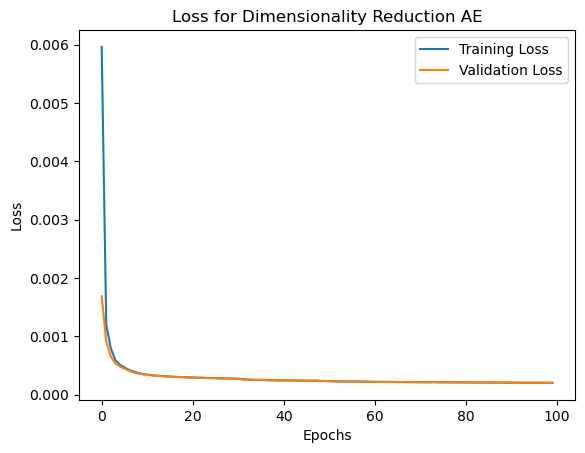

BƯỚC 3: Giảm chiều dữ liệu...
34319/34319 ━━━━━━━━━━━━━━━━━━━━ 30s 857us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 911us/step
Kích thước dữ liệu train sau khi giảm chiều: (1098195, 23)
Kích thước dữ liệu test sau khi giảm chiều: (200000, 23)

BƯỚC 4: Xây dựng và huấn luyện Autoencoder phát hiện bất thường...
Epoch 1/150
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0349 - val_loss: 0.0099
Epoch 2/150
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 3/150
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 4/150
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 5/150
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 6/150
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/150
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/150
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0037 

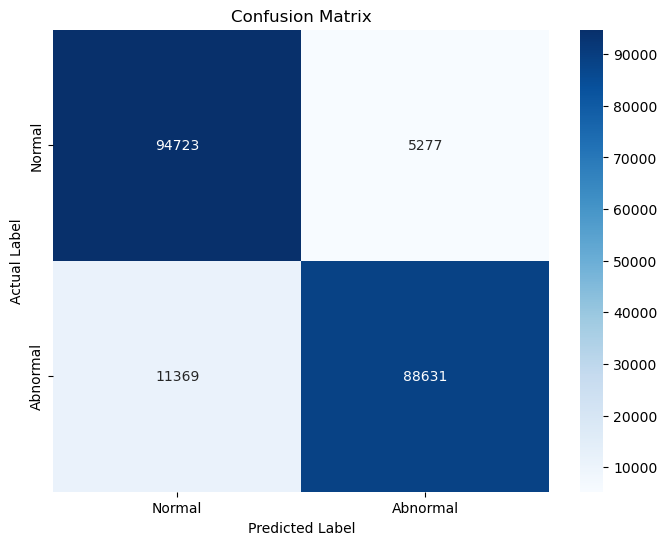

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers # Import regularizers
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# BƯỚC 1: TẢI VÀ CHUẨN BỊ DỮ LIỆU
# ==============================================================================
print("BƯỚC 1: Tải và chuẩn bị dữ liệu...")

try:
    train_df = pd.read_csv('unsupervised_dataset.csv', low_memory=False)
    test_df = pd.read_csv('evaluation_dataset.csv', low_memory=False)
except FileNotFoundError:
    print("LỖI: Không tìm thấy file CSV. Vui lòng đảm bảo các file nằm trong cùng thư mục.")
    exit()

print(f"Kích thước dữ liệu train ban đầu: {train_df.shape}")
print(f"Kích thước dữ liệu test ban đầu: {test_df.shape}")

# Xử lý dữ liệu train
for col in train_df.columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
train_df.fillna(0, inplace=True)

# Xử lý dữ liệu test
label_column_name = test_df.columns[-1] 
feature_columns = test_df.columns[:-1]
for col in feature_columns:
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
test_df.fillna(0, inplace=True)

print("Đã ép kiểu dữ liệu và xử lý giá trị thiếu thành công.")

# Tách dữ liệu (X) và nhãn (y)
X_test_full = test_df.drop(columns=[label_column_name]).values
y_test_full = test_df[label_column_name].values
y_test_binary = np.where(y_test_full == -1, 1, 0)
X_train_full = train_df.values

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

print("Chuẩn bị dữ liệu hoàn tất.\n")

# ==============================================================================
# BƯỚC 2: AUTOENCODER GIẢM CHIỀU (THÊM CƠ CHẾ CHỐNG OVERFITTING)
# ==============================================================================
print("BƯỚC 2: Xây dựng và huấn luyện Autoencoder giảm chiều (chống Overfitting)...")

input_dim = X_train_scaled.shape[1]
encoding_dim = int(input_dim / 2) 
l2_lambda = 1e-5 # Hệ số cho L2 Regularization

# Định nghĩa kiến trúc mô hình với L2 Regularization
input_layer_dr = Input(shape=(input_dim,))
encoder_dr = Dense(encoding_dim * 2, activation="tanh", 
                   kernel_regularizer=regularizers.l2(l2_lambda))(input_layer_dr)
encoder_dr = Dense(encoding_dim, activation="relu",
                   kernel_regularizer=regularizers.l2(l2_lambda))(encoder_dr)
decoder_dr = Dense(encoding_dim * 2, activation='tanh',
                   kernel_regularizer=regularizers.l2(l2_lambda))(encoder_dr)
decoder_dr = Dense(input_dim, activation='sigmoid')(decoder_dr)

autoencoder_dr = Model(inputs=input_layer_dr, outputs=decoder_dr)
autoencoder_dr.compile(optimizer='adam', loss='mean_squared_error')

# Định nghĩa callback EarlyStopping
# 'monitor': theo dõi validation loss
# 'patience': dừng lại nếu val_loss không cải thiện sau 10 epochs
# 'restore_best_weights': khôi phục lại trọng số của epoch có val_loss tốt nhất
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, 
                                        verbose=1, restore_best_weights=True)

# Huấn luyện mô hình với callback
history_dr = autoencoder_dr.fit(X_train_scaled, X_train_scaled,
                               epochs=100, # Tăng epochs vì EarlyStopping sẽ tự dừng
                               batch_size=256,
                               shuffle=True,
                               validation_split=0.2,
                               verbose=1,
                               callbacks=[early_stopping_callback]) # Thêm callback vào đây

print("Huấn luyện Autoencoder giảm chiều hoàn tất.\n")

# Vẽ đồ thị loss để kiểm tra overfitting
plt.plot(history_dr.history['loss'], label='Training Loss')
plt.plot(history_dr.history['val_loss'], label='Validation Loss')
plt.title('Loss for Dimensionality Reduction AE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ==============================================================================
# BƯỚC 3: SỬ DỤNG ENCODER ĐỂ GIẢM CHIỀU DỮ LIỆU
# ==============================================================================
print("BƯỚC 3: Giảm chiều dữ liệu...")

encoder_model = Model(inputs=input_layer_dr, outputs=encoder_dr)
X_train_reduced = encoder_model.predict(X_train_scaled)
X_test_reduced = encoder_model.predict(X_test_scaled)

print(f"Kích thước dữ liệu train sau khi giảm chiều: {X_train_reduced.shape}")
print(f"Kích thước dữ liệu test sau khi giảm chiều: {X_test_reduced.shape}\n")

# ==============================================================================
# BƯỚC 4: AUTOENCODER PHÁT HIỆN BẤT THƯỜNG
# ==============================================================================
print("BƯỚC 4: Xây dựng và huấn luyện Autoencoder phát hiện bất thường...")

input_dim_ad = X_train_reduced.shape[1]
encoding_dim_ad = int(input_dim_ad / 2)

input_layer_ad = Input(shape=(input_dim_ad,))
encoder_ad = Dense(encoding_dim_ad, activation="relu")(input_layer_ad)
decoder_ad = Dense(input_dim_ad, activation='sigmoid')(encoder_ad)

autoencoder_ad = Model(inputs=input_layer_ad, outputs=decoder_ad)
autoencoder_ad.compile(optimizer='adam', loss='mae')

# Dùng EarlyStopping cho mô hình này luôn để tối ưu
history_ad = autoencoder_ad.fit(X_train_reduced, X_train_reduced,
                             epochs=150,
                             batch_size=256,
                             shuffle=True,
                             validation_split=0.2,
                             verbose=1,
                             callbacks=[early_stopping_callback]).history

print("Huấn luyện Autoencoder phát hiện bất thường hoàn tất.\n")

# ==============================================================================
# BƯỚC 5: ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP TEST
# ==============================================================================
print("BƯỚC 5: Đánh giá mô hình trên tập test...")

predictions = autoencoder_ad.predict(X_test_reduced)
mse = np.mean(np.power(X_test_reduced - predictions, 2), axis=1)

train_predictions = autoencoder_ad.predict(X_train_reduced)
train_mse = np.mean(np.power(X_train_reduced - train_predictions, 2), axis=1)

# Tinh chỉnh hệ số này để cân bằng Recall và Precision
HESO_TUYCHINH = 2.0 
threshold = np.mean(train_mse) + HESO_TUYCHINH * np.std(train_mse) 
print(f"Ngưỡng (threshold) được xác định với hệ số {HESO_TUYCHINH} là: {threshold}")

y_pred = (mse > threshold).astype(int)

# ==============================================================================
# BƯỚC 6: HIỂN THỊ KẾT QUẢ ĐÁNH GIÁ
# ==============================================================================
print("\nBƯỚC 6: Kết quả đánh giá hiệu suất mô hình:")

print(f"Accuracy: {accuracy_score(y_test_binary, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_binary, y_pred):.4f}")
print(f"Recall: {recall_score(y_test_binary, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test_binary, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred, target_names=['Normal (0)', 'Abnormal (1)']))

# Vẽ ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test_binary, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Abnormal'], 
            yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [3]:
autoencoder_dr.save('dimensionality_reduction_autoencoder.keras')
print("Mô hình giảm chiều đã được lưu vào file 'dimensionality_reduction_autoencoder.keras'\n")
autoencoder_ad.save('anomaly_detection_autoencoder.keras')
print("Mô hình phát hiện bất thường đã được lưu vào file 'anomaly_detection_autoencoder.keras'\n")

Mô hình giảm chiều đã được lưu vào file 'dimensionality_reduction_autoencoder.keras'

Mô hình phát hiện bất thường đã được lưu vào file 'anomaly_detection_autoencoder.keras'

